In [1]:
import importlib

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch_summarization
importlib.reload(torch_summarization)

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import cv2

In [2]:
def plot_image_grid(images, labels=None, grid_size=(3, 3), figsize=(3, 3)):
    """
    Plot specific images in a grid.
    
    Parameters:
    images: array of torch images
    labels: optional array of corresponding labels
    grid_size: tuple of (rows, cols)
    figsize: figure size in inches
    """
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes if grid_size is (1, n) or (n, 1)
    if rows == 1 or cols == 1:
        axes = axes.flatten()
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            # Display the image
            img = images[i]
            ax.imshow(img, cmap='gray')
            
            # Add label if provided
            if labels is not None:
                ax.set_title(f'Label: {labels[i]}')
            
            # Remove ticks
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Hide empty subplots
            ax.axis('off')
    
    plt.tight_layout()
    return fig

In [4]:
def exponential_class_imbalance_dataset(full_dataset, max_size=5000, decay_rate=1.0, seed=42, min_size:int=1, randomize_class_sizes=False):
    """
    Subsample CIFAR-10 dataset with exponentially decreasing samples per class.
    
    Args:
        max_size (int): Number of samples for the first class (default 3160)
        decay_rate (float): Rate of exponential decay (default 1.0)
        seed (int): Random seed for reproducibility
    
    Returns:
        subsampled_dataset: Subset of a pytorch dataset
        class_sizes (list): Number of samples per class
    """
    # Set random seed
    np.random.seed(seed)

    num_classes = len(np.unique(full_dataset.targets))
    
    # Calculate exponentially decreasing class sizes
    class_sizes = [
        max(int(max_size * np.exp(-decay_rate * i)), min_size)
        for i in range(num_classes)
    ]

    if randomize_class_sizes:
        rng = np.random.default_rng()
        class_sizes = rng.permutation(class_sizes)
    
    # Get indices for each class
    class_indices = [[] for _ in range(10)]
    for idx, (_, label) in enumerate(full_dataset):
        class_indices[label].append(idx)
    
    # Randomly sample indices for each class according to desired sizes
    selected_indices = []
    for class_idx in range(10):
        sample_size = min(class_sizes[class_idx], len(class_indices[class_idx]))
        selected_indices.extend(
            np.random.choice(
                class_indices[class_idx],
                size=sample_size,
                replace=False
            )
        )
    
    # Create subsampled dataset
    subsampled_dataset = torch.utils.data.Subset(full_dataset, selected_indices)
    
    # Print class distribution
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
    print("Class distribution:")
    for class_idx, (name, size) in enumerate(zip(class_names, class_sizes)):
        print(f"{name}: {size}")
    
    return subsampled_dataset, class_sizes



In [5]:
def linear_class_imbalance_dataset(full_dataset, max_size:int=5000, min_size:int=1, seed=42, randomize_class_sizes=False):
    """
    Subsample dataset with class imbalance in linearly decreasing samples per class.
    
    Args:
        max_size (int): Number of samples for the first class (default 3160)
        seed (int): Random seed for reproducibility
    
    Returns:
        subsampled_dataset: Subset of a dataset
        class_sizes (list): Number of samples per class
    """
    # Set random seed
    np.random.seed(seed)

    num_classes = len(np.unique(full_dataset.targets))
    
    # Calculate linearly decreasing class sizes
    class_sizes = np.linspace(max_size, min_size, num_classes).astype(int)

    if randomize_class_sizes:
        rng = np.random.default_rng()
        class_sizes = rng.permutation(class_sizes)
    
    # Get indices for each class
    class_indices = [[] for _ in range(10)]
    for idx, (_, label) in enumerate(full_dataset):
        class_indices[label].append(idx)
    
    # Randomly sample indices for each class according to desired sizes
    selected_indices = []
    for class_idx in range(10):
        sample_size = min(class_sizes[class_idx], len(class_indices[class_idx]))
        selected_indices.extend(
            np.random.choice(
                class_indices[class_idx],
                size=sample_size,
                replace=False
            )
        )
    
    # Create subsampled dataset
    subsampled_dataset = torch.utils.data.Subset(full_dataset, selected_indices)
    
    # Print class distribution
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']
    print("Class distribution:")
    for class_idx, (name, size) in enumerate(zip(class_names, class_sizes)):
        print(f"{name}: {size}")
    
    return subsampled_dataset, class_sizes

In [6]:
# Load embeddings if they already exist
if os.path.exists("cifar_train_dinov2_embeddings.npy"):
    # Load training data
    train_embeddings = np.load("cifar_train_dinov2_embeddings.npy")
    train_labels = np.load("cifar_train_dinov2_labels.npy")
    train_tsne_proj = np.load("cifar_train_dinov2_projections.npy")

    # Load test data
    test_embeddings = np.load("cifar_test_dinov2_embeddings.npy")
    test_labels = np.load("cifar_test_dinov2_labels.npy")
    test_tsne_proj = np.load("cifar_test_dinov2_projections.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'cifar_test_dinov2_embeddings.npy'

In [5]:
# Download DinoV2 model from torch hub
device = "cuda:0"
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_model.to(device)
dinov2_model.eval()  # Set to evaluation mode

# Prepare MNIST dataset
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # DinoV2 expects 224x224 images
#     transforms.Grayscale(3),  # Convert single-channel to 3-channel
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
# ])
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DinoV2 expects 224x224 images
    transforms.ToTensor()
])

# Load MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create imbalanced dataset
# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataset, class_balances = exponential_class_imbalance_dataset(train_dataset, decay_rate=1.0)
# train_dataset, class_balances = linear_class_imbalance_dataset(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Using cache found in /home/lcai/.cache/torch/hub/facebookresearch_dinov2_main


Files already downloaded and verified
Class distribution:
airplane: 5000
automobile: 1839
bird: 676
cat: 248
deer: 91
dog: 33
frog: 12
horse: 4
ship: 1
truck: 1
Files already downloaded and verified


In [9]:
 x = dinov2_model(images)

In [11]:
# Extract embeddings
train_embeddings = []
train_labels = []

test_embeddings = []
test_labels = []

print("Extracting DINO features...")

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        # Extract features using DinoV2
        images, labels = images.to(device), labels.to(device)
        # features = dinov2_model.forward_features(images)['x_norm_patchtokens'].mean(1)
        features = dinov2_model(images)
        
        train_embeddings.append(features.cpu().numpy())
        train_labels.append(labels.cpu().numpy())

    for images, labels in tqdm(test_loader):
        # Extract features using DinoV2
        images, labels = images.to(device), labels.to(device)
        # features = dinov2_model.forward_features(images)['x_norm_patchtokens'].mean(1)
        features = dinov2_model(images)
        
        test_embeddings.append(features.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

# Concatenate embeddings and labels
train_embeddings = np.concatenate(train_embeddings, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

print(f"Extracted embeddings shape: {train_embeddings.shape}")
print(f"Labels shape: {train_labels.shape}")

# Optional: Save embeddings
np.save('cifar_train_dinov2_embeddings.npy', train_embeddings)
np.save('cifar_train_dinov2_labels.npy', train_labels)

np.save('cifar_train_dinov2_embeddings.npy', test_embeddings)
np.save('cifar_train_dinov2_labels.npy', test_labels)

Extracting DINO features...


100%|██████████| 157/157 [00:16<00:00,  9.42it/s]

Extracted embeddings shape: (7905, 384)
Labels shape: (7905,)


In [56]:
# Extract TSNE projections
tsne = TSNE(n_components=2, random_state=0)

train_tsne_proj = tsne.fit_transform(train_embeddings)
np.save('cifar_train_dinov2_projections.npy', train_tsne_proj)

test_tsne_proj = tsne.fit_transform(test_embeddings)
np.save('cifar_test_dinov2_projections.npy', test_tsne_proj)

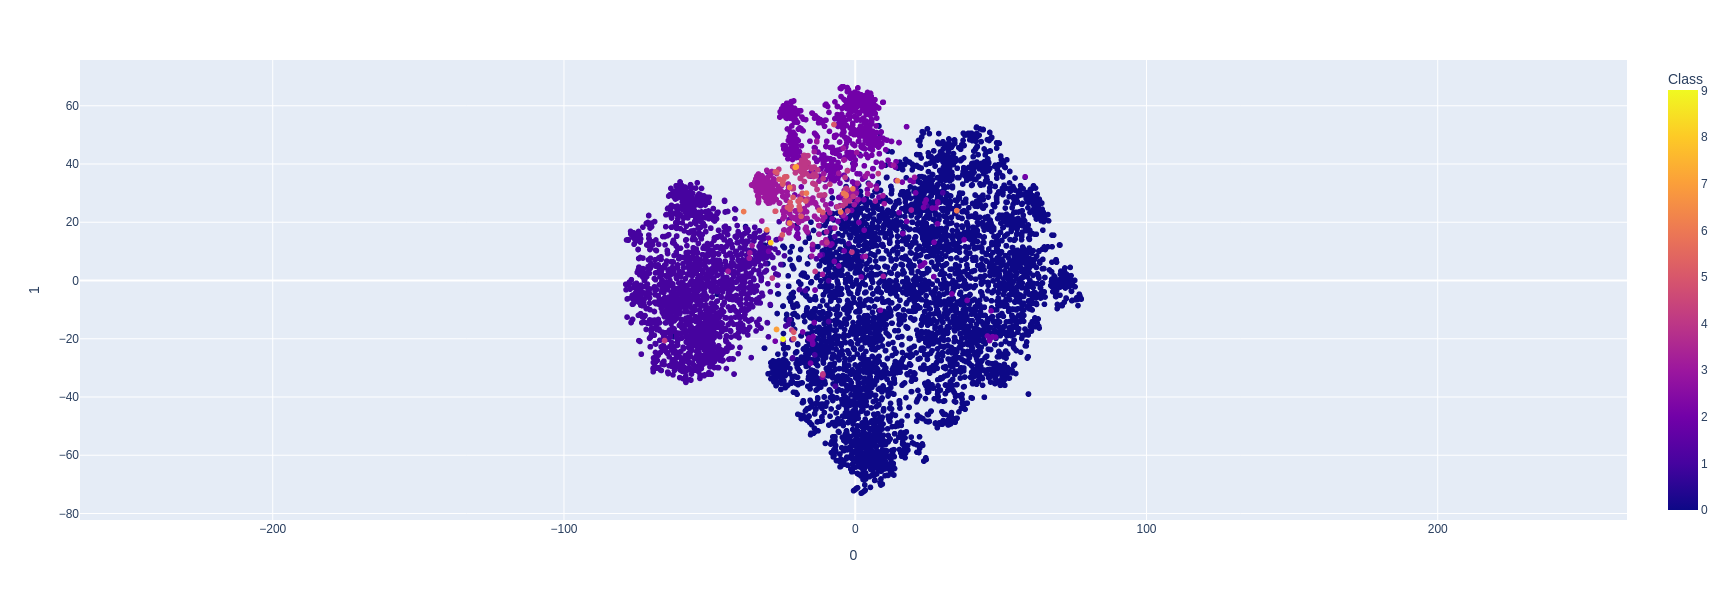

In [57]:
# Plot TSNE of training data
fig = px.scatter(
    train_tsne_proj, x=0, y=1,
    color=train_labels, labels={'color': 'Class'}
)

fig.update_layout(
    width=600,  # Set width and height equal
    height=600,
    yaxis=dict(
        scaleanchor="x",  # This is key - it forces equal scaling
        scaleratio=1,     # Ratio of 1:1
    )
)

fig.show()

In [58]:
# Plot TSNE of test data
fig = px.scatter(
    test_tsne_proj, x=0, y=1,
    color=test_labels, labels={'color': 'Class'}
)

fig.update_layout(
    width=600,  # Set width and height equal
    height=600,
    yaxis=dict(
        scaleanchor="x",  # This is key - it forces equal scaling
        scaleratio=1,     # Ratio of 1:1
    )
)

fig.show()

In [ ]:
# # TSNE plots of raw flattened image space (without DINOv2 transform)
# # THIS IS EXTREMELY SLOW DUE TO THE LARGE FEATURE SPACE OF THE FLATTENED IMAGES
# train_flattened = []
# for images, labels in tqdm(mnist_train_loader):
#     # Extract features using DinoV2
#     flattened = torch.flatten(images, start_dim=1)
    
#     train_flattened.append(flattened.numpy())
# train_flattened = np.concatenate(train_flattened, axis=0)

# tsne = TSNE(n_components=2, random_state=0)
# train_flattened_tsne_proj = tsne.fit_transform(train_flattened)

# # Plot TSNE of test data
# fig = px.scatter(
#     train_flattened_tsne_proj, x=0, y=1,
#     color=train_labels, labels={'color': 'Class'}
# )

# fig.update_layout(
#     width=600,  # Set width and height equal
#     height=600,
#     yaxis=dict(
#         scaleanchor="x",  # This is key - it forces equal scaling
#         scaleratio=1,     # Ratio of 1:1
#     )
# )

# fig.show()

In [59]:
# Extract K-centers
importlib.reload(torch_summarization)
K = 10
center_inds, centers = torch_summarization.kcenters_greedy_index(torch.tensor(train_embeddings), K, dist_func="norm_l2", init_samples="random", device="cuda:0")
centers_labels = [train_dataset[c][1] for c in center_inds]

print("center inds: ", center_inds)
# print("centers: ", centers)
print("labels: ", centers_labels)

center inds:  tensor([7755, 7218, 3299, 5047, 7095, 3308, 6212, 7235, 1702, 3791],
       device='cuda:0')
labels:  [3, 2, 0, 1, 2, 0, 1, 2, 0, 0]


In [60]:
sizes = [40 if i in center_inds else 1 for i in range(len(train_tsne_proj))]
symbols = ["star" if i in center_inds else "circle" for i in range(len(train_tsne_proj))]

fig = px.scatter(
    train_tsne_proj, x=0, y=1,
    color=train_labels, labels={'color': 'Number'},
    symbol_sequence=symbols,
    size=sizes
)

fig.update_layout(
    width=600,  # Set width and height equal
    height=600,
    yaxis=dict(
        #scaleanchor="x",  # This is key - it forces equal scaling
        scaleratio=1,     # Ratio of 1:1
    ),
)

fig.update_layout(
    title={
        'text': "CIFAR10-DINO tSNE with K-centers Core-set selection",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()


In [61]:
# Extract K-centers
importlib.reload(torch_summarization)
K = 100
center_inds, centers = torch_summarization.kcenters_greedy_index(torch.tensor(train_embeddings), K, dist_func="norm_l2", init_samples="random", device="cuda:0")
centers_labels = [train_dataset[c][1] for c in center_inds]

In [62]:
sizes = [40 if i in center_inds else 1 for i in range(len(train_tsne_proj))]
symbols = ["star" if i in center_inds else "circle" for i in range(len(train_tsne_proj))]

fig = px.scatter(
    train_tsne_proj, x=0, y=1,
    color=train_labels, labels={'color': 'Class'},
    symbol_sequence=symbols,
    size=sizes
)

fig.update_layout(
    width=600,  # Set width and height equal
    height=600,
    yaxis=dict(
        #scaleanchor="x",  # This is key - it forces equal scaling
        scaleratio=1,     # Ratio of 1:1
    ),
)

fig.update_layout(
    title={
        'text': "CIFAR10-DINO tSNE with K-centers Core-set selection",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

[0 1 2 3 4 5 6 7 8 9]
[7 2 7 5 3 4 9 1 2 1 7 5 6 1 8 2 6 3 5 6 1 9 6 8 1 3 9 9 0 6 5 7 1 2 9 2 4
 4 3 4 9 7 3 2 6 9 6 1 0 2 5 6 9 1 8 8 1 4 4 3 9 4 3 9 6 5 7 6 8 4 8 3 9 0
 7 7 9 2 2 0 2 6 9 7 8 0 5 6 9 0 0 2 7 5 6 7 7 9 3 7]


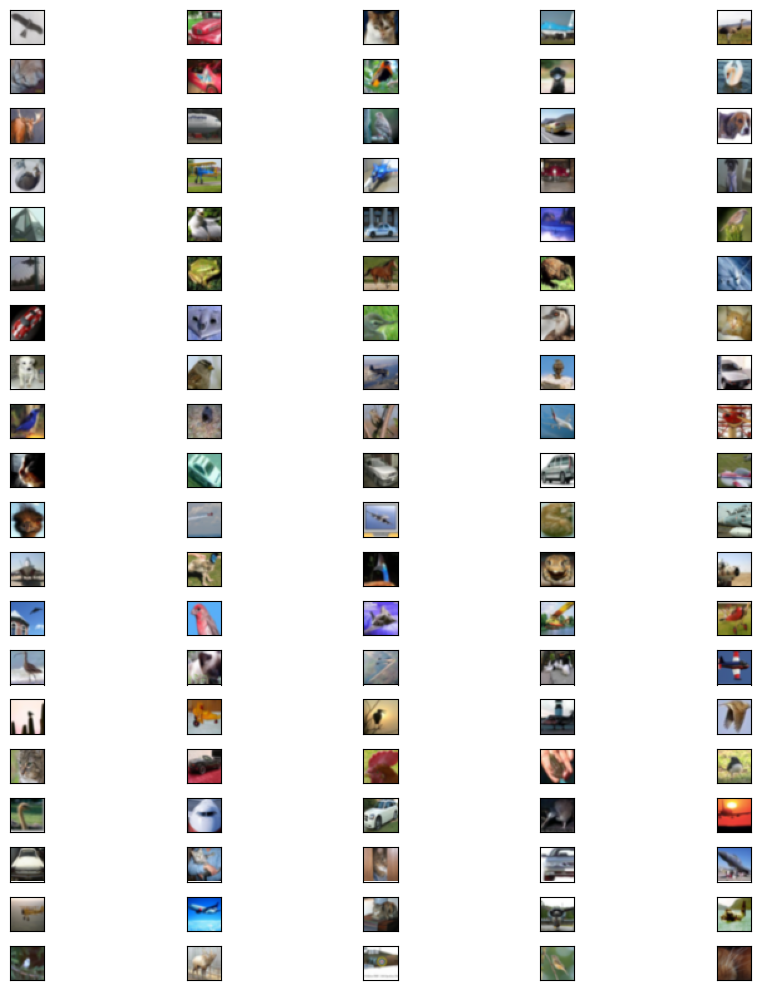

In [70]:
# Plot the representative MNIST core set
plot_size = (28,28)
resize_transform = transforms.Resize(plot_size)  # height, width
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert single-channel to 3-channel
    transforms.ToTensor(),
])
# mnist_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

imgs = [np.transpose(resize_transform(train_dataset[i][0]), (1,2,0)) for i in center_inds]
plot_image_grid(imgs, grid_size=(20, 5), figsize=(10,10))

print(np.unique(np.array(train_dataset.dataset.targets)[center_inds.cpu()]))
print(np.array(train_dataset.dataset.targets)[center_inds.cpu()])

In [71]:
# Setup training parameters
from torchvision.models import resnet18

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
batch_size = 64
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 32x32 images minimum
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [72]:
def eval_model(model, test_loader, device="cuda", verbose=False):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    if verbose:
        print(f'Test Accuracy: {100 * correct / total:.2f}%')
    return 100 * correct / total
    
def train_model(model, train_loader, device="cuda", verbose=False):
    model.to(device)
    model.train()

    # Loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in tqdm(enumerate(train_loader), disable=~verbose):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        if verbose:
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Loss: {running_loss / 100:.4f}, '
              f'Accuracy: {100 * correct / total:.2f}%')
    return model

def init_mnist_resnet_model(device="cuda"):
    model = resnet18(pretrained=False)
    # Modify first layer to accept single channel input
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Modify final layer to output 10 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    return model

def init_cifar10_resnet_model(device="cuda"):
    model = resnet18(pretrained=False)
    # Modify first layer to accept single channel input
    # model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Modify final layer to output 10 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    return model

# model = init_cifar10_resnet_model()

# # Load MNIST dataset
# cifar10_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=64, shuffle=False)

# cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=64, shuffle=False)

# model = train_model(model, cifar10_train_loader)
# eval_model(model, cifar10_test_loader)

In [ ]:
# Train an MNIST classifier with increasing core-set size
importlib.reload(torch_summarization)

# coreset_ratio = [0.1, 0.5, 1.0]
# coreset_ratio = [0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.0011]
# coreset_ratio = [0.0001, 0.001, 0.01, 0.1]
coreset_ratio = [0.0001, 0.1, 0.3, 0.5, 0.7]
seeds = [42, 0, 1223, 342325, 13241, 123453670, 856264]
# seeds = [42, 0, 1223]

coreset_test_accuracies = np.zeros((len(coreset_ratio), len(seeds)))
unif_test_accuracies = np.zeros((len(coreset_ratio), len(seeds)))

for iseed, seed in enumerate(seeds):
    torch.manual_seed(seed)

    print(f"====seed {seed}=====")
    for irt, rt in enumerate(coreset_ratio):
        K = int(len(train_labels) * rt)
        print("====")
        print("Core-set Ratio: ", rt)
        center_inds, centers = torch_summarization.kcenters_greedy_index(torch.tensor(train_embeddings), K, dist_func="norm_l2", init_samples="random", device="cuda:0")
        # centers_labels = [mnist_dataset[c][1] for c in center_inds]
        
        train_subset = torch.utils.data.Subset(train_dataset, center_inds)
        subset_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=False)
        model = init_cifar10_resnet_model()
        model = train_model(model, subset_loader)
        acc = eval_model(model, test_loader)
        coreset_test_accuracies[irt, iseed] = acc
        print("Core-set acc: ", acc)
    
        print("Random ratio: ", rt)
        uniform_inds = np.random.choice(range(len(train_embeddings)), size=K, replace=False)
        train_subset = torch.utils.data.Subset(train_dataset, uniform_inds)
        subset_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=False)
        model = init_cifar10_resnet_model()
        model = train_model(model, subset_loader)
        acc = eval_model(model, test_loader)
        unif_test_accuracies[irt, iseed] = acc
        print("Unif. acc: ", acc)
    

====seed 42=====
====
Core-set Ratio:  0.0001


/home/lcai/miniconda3/envs/data-summarization/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/lcai/miniconda3/envs/data-summarization/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



Core-set acc:  10.0
Random ratio:  0.0001
Unif. acc:  11.14
====
Core-set Ratio:  0.1
Core-set acc:  22.87
Random ratio:  0.1
Unif. acc:  17.78
====
Core-set Ratio:  0.3
Core-set acc:  23.32
Random ratio:  0.3


In [75]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def plot_dual_stats_matplotlib(data1, data2, label1="Dataset 1", label2="Dataset 2"):
    """
    Plot mean and standard deviation for two datasets using Matplotlib
    
    Parameters:
    data1, data2: 2D numpy arrays
    label1, label2: Labels for the datasets
    """
    # Calculate statistics for both datasets
    means1 = np.mean(data1, axis=1)
    stds1 = np.std(data1, axis=1)
    means2 = np.mean(data2, axis=1)
    stds2 = np.std(data2, axis=1)
    
    # Create x-axis points
    x = np.arange(len(means1))
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    
    # Plot first dataset
    plt.errorbar(x - 0.1, means1, yerr=stds1, fmt='o-', capsize=5, 
                 color='blue', ecolor='lightblue', 
                 label=f'{label1} (Mean ± Std Dev)')
    
    # Plot second dataset
    plt.errorbar(x + 0.1, means2, yerr=stds2, fmt='o-', capsize=5, 
                 color='red', ecolor='lightcoral', 
                 label=f'{label2} (Mean ± Std Dev)')
    
    # Customize the plot
    plt.xlabel('Row Index')
    plt.ylabel('Value')
    plt.title('Comparison of Means and Standard Deviations')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.show()

def plot_dual_stats_plotly(data1, data2, x=None, label1="Dataset 1", label2="Dataset 2"):
    """
    Plot mean and standard deviation for two datasets using Plotly
    
    Parameters:
    data1, data2: 2D numpy arrays
    label1, label2: Labels for the datasets
    """
    # Calculate statistics for both datasets
    means1 = np.mean(data1, axis=1)
    stds1 = np.std(data1, axis=1)
    means2 = np.mean(data2, axis=1)
    stds2 = np.std(data2, axis=1)
    
    # Create x-axis points
    if x == None:
        x = np.arange(len(means1))
    
    # Create the plot
    fig = go.Figure()
    
    # Add first dataset
    fig.add_trace(go.Scatter(
        x=x,
        y=means1,
        error_y=dict(
            type='data',
            array=stds1,
            visible=True
        ),
        mode='lines+markers',
        name=f'{label1}',
        line=dict(color='blue'),
        marker=dict(color='blue')
    ))
    
    # Add second dataset
    fig.add_trace(go.Scatter(
        x=x,
        y=means2,
        error_y=dict(
            type='data',
            array=stds2,
            visible=True
        ),
        mode='lines+markers',
        name=f'{label2}',
        line=dict(color='red'),
        marker=dict(color='red')
    ))
    
    # Update layout
    fig.update_layout(
        title='CIFAR10-LT Classification Performance for Core-set Selection Methods',
        xaxis_title='% dataset used for training',
        yaxis_title='% Performance',
        showlegend=True,
        template='plotly_white'
    )

    fig.update_layout(
        width=600,  # Set width and height equal
        height=600,
        yaxis=dict(
            #scaleanchor="x",  # This is key - it forces equal scaling
            scaleratio=1,     # Ratio of 1:1
        ),
    )
    
    # Show the plot
    fig.show()
plot_dual_stats_plotly(coreset_test_accuracies, unif_test_accuracies, x=coreset_ratio, label1="coreset", label2="uniform")
coreset_test_accuracies.shape


(5, 7)